# Data Preprocessing

In [ ]:
import random
import torch
import numpy as np

def seed_all(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False
seed_all(42)

In [ ]:
import pickle

with open('funny_quotes.pkl', 'rb') as f:
    funny_quotes = pickle.load(f)

with open('not_funny_quotes.pkl', 'rb') as f:
    not_funny_quotes = pickle.load(f)

In [ ]:
import re

def list2clean_list(quotes: list[str]) -> list[str]:
    quotes_dict = {}
    for quote in quotes:
        clean_quote = quote
        if quote[-1].isalpha():
            clean_quote += '.'
        quotes_dict[clean_quote.replace('\n', ' ')] = quote
    return quotes_dict

quotes_dict = list2clean_list(funny_quotes)

In [ ]:
import re

def list2clean_list(quotes: list[str]) -> list[str]:
    quotes_clean = []
    for quote in quotes:
        clean_quote = quote
        if (quote == '' or len(quote) < 5) and False:
          continue
        elif quote[-1].isalpha():
            clean_quote = quote + '.'
        clean_quote = clean_quote.replace('!', '.')
        clean_quote = clean_quote.replace('?..', '?')
        clean_quote = clean_quote.replace('?.', '?')
        clean_quote = clean_quote.replace('\n\n', '\n')
        clean_quote = clean_quote.replace('...', '.')
        clean_quote = clean_quote.replace('..', '.')
        clean_quote = clean_quote.replace('  ', ' ')

        clean_quote = clean_quote.replace('"', '')
        clean_quote = clean_quote.replace("'", '')
        quotes_clean.append(clean_quote)
    return quotes_clean

not_funny_quotes = list2clean_list(not_funny_quotes)
funny_quotes = list2clean_list(funny_quotes)

In [ ]:
import pandas as pd

df_funny_quotes = pd.DataFrame(columns=['text', 'target'])
df_not_funny_quotes = pd.DataFrame(columns=['text', 'target'])

In [ ]:
df_funny_quotes.text = funny_quotes
df_funny_quotes.target = 1

df_not_funny_quotes.text = not_funny_quotes
df_not_funny_quotes.target = 0

df = pd.concat([df_funny_quotes, df_not_funny_quotes])

In [ ]:
df

,text,target
0,"Как-то в Африке прихожу к консулу, говорю, мол...",1
1,Я бы в Вышке не смог учиться: столько экзаменов.,1
2,Преподаватель: Ролан Барт здесь?\nСтудент: Зде...,1
3,Ученик: вышкинцев часть коры головного мозга о...,1
4,Лекция - это акт любви. А записывать акты любв...,1
...,...,...
11580,Перед казнью – на отработку.,0
11581,Сессия - это вам не баран чихнул.,0
11582,"Не спеши, а то успеешь.",0
11583,Вообще-то рэп придумал Маяковский.,0


In [ ]:
len(df_funny_quotes)

8742

In [ ]:
len(df_not_funny_quotes)

11585

In [ ]:
from sklearn.model_selection import train_test_split

train_funny, test_funny = train_test_split(df_funny_quotes, test_size=0.3, random_state=17)
train_not_funny, test_not_funny = train_test_split(df_not_funny_quotes, test_size=0.15, random_state=17)

In [1]:
print(len(test_funny))
print(len(test_not_funny))

2623
1738


In [ ]:
train = pd.concat([train_funny, train_not_funny])
test = pd.concat([test_funny, test_not_funny])

In [2]:
print(len(train)) # 32869
print(len(test)) # 5178

32869
5178


In [ ]:
test.target.value_counts()

,count
target,
1,2623
0,2555


In [ ]:
seq_len_train = [len(str(i).split()) for i in train.text]
seq_len_test = [len(str(i).split()) for i in test.text]
max_seq_len = max(max(seq_len_test), max(seq_len_train))
max_seq_len

89

# BERT Training

In [ ]:
import random
import torch
import numpy as np

def seed_all(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False
seed_all(42)

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

tokenizer = BertTokenizer.from_pretrained('cointegrated/rubert-tiny2')
model = BertForSequenceClassification.from_pretrained('cointegrated/rubert-tiny2', num_labels=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import pickle

with open('quotes_ml_train.pkl', 'rb') as f:
    train = pickle.load(f)

with open('quotes_ml_test.pkl', 'rb') as f:
    test = pickle.load(f)

train = train.sample(frac=1)
test = test.sample(frac=1)

In [ ]:
train = train.drop_duplicates()
test = test.drop_duplicates()

In [ ]:
X_train_tokenized = tokenizer(list(train.text), padding='max_length', max_length=200)
X_test_tokenized = tokenizer(list(test.text), padding='max_length', max_length=200)

In [ ]:
import numpy as np
import torch

class Data(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Data(X_train_tokenized, np.array(train.target))
test_dataset = Data(X_test_tokenized, np.array(test.target))

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    recall = recall_score(labels, preds)
    precision = precision_score(labels, preds)
    roc_auc = roc_auc_score(labels, preds)
    return {'acc': acc, 'f1': f1, 'recall': recall, 'precision': precision,
            'roc_auc': roc_auc}

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir = './results',
    num_train_epochs = 4,
    learning_rate = 1e-5,
    eval_strategy = 'epoch',
    load_best_model_at_end = True,
    save_strategy = 'epoch',
    seed = 17
)

trainer = Trainer(
    model = model,
    tokenizer = tokenizer,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = test_dataset,
    compute_metrics = compute_metrics
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Acc,F1,Recall,Precision,Roc Auc
1,0.484900,0.542032,0.723656,0.689354,0.604207,0.802438,0.725468
2,0.462000,0.505937,0.753154,0.737840,0.684512,0.800179,0.754195
3,0.410400,0.531929,0.752183,0.728702,0.655832,0.819790,0.753645
4,0.393500,0.539793,0.754124,0.730023,0.655067,0.824350,0.755626


TrainOutput(global_step=9344, training_loss=0.4440191249324851, metrics={'train_runtime': 307.3426, 'train_samples_per_second': 243.142, 'train_steps_per_second': 30.403, 'total_flos': 215257710508800.0, 'train_loss': 0.4440191249324851, 'epoch': 4.0})

In [ ]:
import torch.nn.functional as F

def get_prediction(dataset, threshold: float):
  softmax_predictions = []
  predictions = torch.tensor(trainer.predict(dataset).predictions)
  for predictions in predictions:
      softmax_predictions.append(int(round(torch.softmax(predictions, 0)[1].item(), 3) > threshold))
  return np.array(softmax_predictions)

In [ ]:
f1_scores = []
x = []
for threshold in np.arange(0, 1, 0.05):
    f1_scores.append(f1_score(test.target, get_prediction(test_dataset, threshold)))
    x.append(threshold)

In [ ]:
def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=200).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits[0]
    prediction = torch.softmax(logits, dim=-1)[1].item()

    return prediction

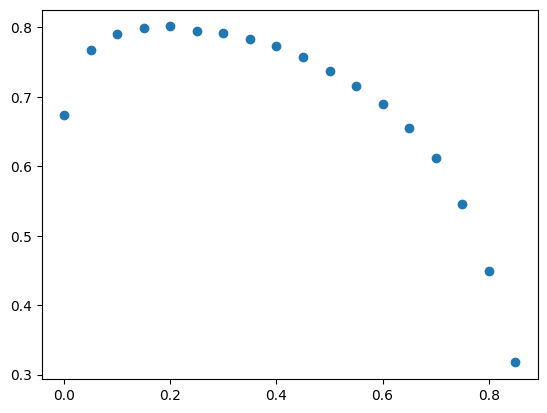

In [ ]:
# x = [i for i in range(len(f1_scores))]
plt.scatter(x, f1_scores)
plt.show()

In [ ]:
fun_texts = [
    "Каждый день я покупаю водку. Я шопоголик?",
    "Звание Психолог года в очередной раз завоевала водка.",
    "Больше знаешь — крепче пьёшь.",
    "Он конечно не был орлом, но за пивом летал быстро.",
    "— сухое вино будешь? — насыпай…",
    "Вино желтого цвета называют белым, потому что оно сделано из зеленого винограда. К черту логику.",
    "На моих лекциях запрещено пить."
]

In [ ]:
X_fun_tokenized = tokenizer(fun_texts, padding=True, truncation=True, max_length=200)

fun_dataset = Data(X_fun_tokenized, np.array([0, 0, 0, 0, 1, 0, 0]))

get_prediction(fun_dataset)

array([[0.   , 0.037],
       [1.   , 0.615],
       [0.   , 0.017],
       [1.   , 0.249],
       [0.   , 0.035],
       [1.   , 0.582],
       [1.   , 0.266]])